###### Домашнее задание1.
**Задача** - ответить на вопрос есть ли связь между жёсткостью воды и средней годовой смертностью?

a.Построить точечный график

b.Рассчитать коэффициенты корреляции Пирсона и Спирмена

c.Построить модель линейной регрессии

d.Рассчитать коэффициент детерминации

e.Вывести график остатков

2.Сохраняется ли аналогичная зависимость для северных и южных городов по отдельности?

a.Разделить данные на 2 группы

b.Повторить аналогичные шаги из пункта 1 для каждой группы по отдельности


In [80]:
import pandas as pd
import numpy as np
from tabulate import tabulate
import matplotlib.pyplot as plt
import seaborn as sns

In [81]:
df = pd.read_csv('water.csv', usecols=["location", "town", "mortality","hardness"])
                        
# какие типы признаков в нашем датафрейме?
df.head()

,location,town,mortality,hardness
0,South,Bath,1247,105
1,North,Birkenhead,1668,17
2,South,Birmingham,1466,5
3,North,Blackburn,1800,14
4,North,Blackpool,1609,18


In [82]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61 entries, 0 to 60
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   location   61 non-null     object
 1   town       61 non-null     object
 2   mortality  61 non-null     int64 
 3   hardness   61 non-null     int64 
dtypes: int64(2), object(2)
memory usage: 2.0+ KB


**Вывод:** Пропусков в данных не имеется. Типы данных определены корректно.

In [83]:
# уточним тип данных для столбцов location и town- категориальных переменных:
df['location'] = df['location'].astype('category')
df['town'] = df['town'].astype('category')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61 entries, 0 to 60
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   location   61 non-null     category
 1   town       61 non-null     category
 2   mortality  61 non-null     int64   
 3   hardness   61 non-null     int64   
dtypes: category(2), int64(2)
memory usage: 4.3 KB


In [84]:
df.describe()

,mortality,hardness
count,61.000000,61.000000
mean,1524.147541,47.180328
std,187.668754,38.093966
min,1096.000000,5.000000
25%,1379.000000,14.000000
50%,1555.000000,39.000000
75%,1668.000000,75.000000
max,1987.000000,138.000000


###### Бокс-плоты для данных жёсткости воды и смертности



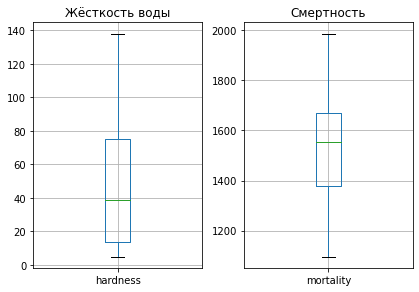

In [85]:
fig,axes = plt.subplots(nrows=1, ncols=2)
fig. tight_layout() # отодвинуть графики

df['hardness'].plot(ax=axes[0], kind='box',
                   title='Жёсткость воды', grid=True)


df['mortality'].plot(ax=axes[1], kind='box',
                   title='Смертность', grid=True)

In [86]:
# Расчёт выбросов для столбца hardness по «внутренним границам»:
q1 = df['hardness'].quantile(0.25)
q3 = df['hardness'].quantile(0.75)
iqr = q3 - q1
lower_bound_int = q1 - (1.5 * iqr) 
upper_bound_int = q3 + (1.5 * iqr)
print ('Значение выбросов столбца "hardness" по "внутренним границам" (1,5 межквартильного размаха):')
df[~df['hardness'].between(lower_bound_int, upper_bound_int, inclusive=True)]

Значение выбросов столбца "hardness" по "внутренним границам" (1,5 межквартильного размаха):


,location,town,mortality,hardness


In [87]:
# Расчёт выбросов для столбца mortality по «внутренним границам»:
q1 = df['mortality'].quantile(0.25)
q3 = df['mortality'].quantile(0.75)
iqr = q3 - q1
lower_bound_int = q1 - (1.5 * iqr) 
upper_bound_int = q3 + (1.5 * iqr)
print ('Значение выбросов столбца "mortality" по "внутренним границам" (1,5 межквартильного размаха):')
df[~df['mortality'].between(lower_bound_int, upper_bound_int, inclusive=True)]

Значение выбросов столбца "mortality" по "внутренним границам" (1,5 межквартильного размаха):


,location,town,mortality,hardness


**Вывод:** выбросов в столбцах данных mortality и hardness не обнаружено. Можно применять критерий Пирсона.

**a. Построить точечный график**

#### Диаграмма рассеяния

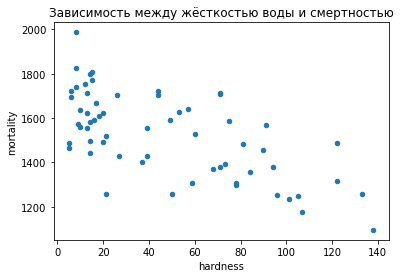

In [88]:
# посмотрим графически на взаимосвязь между жёсткостью воды и смертностью
df.plot(kind='scatter', 
        x='hardness', 
        y='mortality', 
        title='Зависимость между жёсткостью воды и смертностью')


**Вывод:** Визуально наблюдается обратная корреляция.

**b. Рассчитать коэффициенты корреляции Пирсона и Спирмена**

In [89]:
# считаем коэф. корреляции Пирсона
df[['hardness',  'mortality']].corr()

,hardness,mortality
hardness,1.000000,-0.654849
mortality,-0.654849,1.000000


In [90]:
# считаем коэф. корреляции Спирмана
df[['hardness',  'mortality']].corr(method='spearman')

,hardness,mortality
hardness,1.000000,-0.631665
mortality,-0.631665,1.000000


**Вывод**: Эмпирически связь между показателями жёсткости воды и смертности, расчитанными по методам Пирсона и  Спирмана является *сильной*, что однако не означает наличие причиннно-следственных связей между данными показателями.

**c. Построить модель линейной регрессии**

In [91]:
# Грузим библиотеки 

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

Создаем массивы:
**X** - по умолчанию многомерный массив (вектор) исходных параметров для прогноза, в нашем случае только 1 параметр -  *hardness*.
**y** - выходной прогнозный параметр -  *mortality* смертность.

In [92]:
X = df[['hardness']]
y = df['mortality']

Выполним разбиение с паметром - train_size=0.67 - **67%** для обучения модели, **33%** - для тестирования) 

In [93]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.67, random_state=42)
print (f'Всего строк в датасете: {len(df)}')
print(f"Количество строк в y_train - выборка для обучения: {len(y_train)}")
print(f"Количество строк в y_test -выборка дляя тестирования: {len(y_test)}")

Всего строк в датасете: 61
Количество строк в y_train - выборка для обучения: 40
Количество строк в y_test -выборка дляя тестирования: 21


In [94]:
model = LinearRegression()
model.fit(X_train, y_train)  # метод обучается на данных и подбирает оптимальные коэффициенты

LinearRegression()

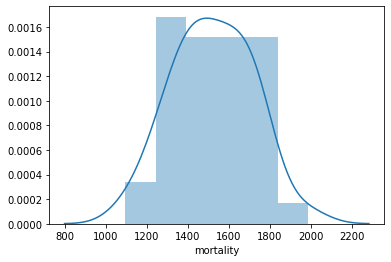

In [95]:
sns.distplot(y_train)

Пробуем выполнить предсказание для известной части данных из X_test:

In [96]:
y_pred = model.predict(X_test)
y_pred

array([1338.09462969, 1636.02079457, 1623.476535  , 1529.39458819,
       1422.76838181, 1604.66014564, 1250.28481267, 1432.17657649,
       1601.52408074, 1648.56505414, 1482.35361479, 1413.36018713,
       1545.07491266, 1623.476535  , 1444.72083607, 1545.07491266,
       1636.02079457, 1620.3404701 , 1350.63888926, 1610.93227542,
       1513.71426372])

In [97]:
print(type(y_test))
i = 1
y_test.index

<class 'pandas.core.series.Series'>


Int64Index([0, 5, 46, 31, 13, 55, 34, 49, 12, 40, 33, 59, 16, 3, 53, 17, 8, 6,
            41, 4, 44],
           dtype='int64')

**Сравним значения предсказанные моделью с реальными значениями:**

In [98]:
i = 0
for y_test_val in y_test:
    print(f'{i+1:2d}. Реальное значение смертности:{y_test_val} смоделированное значение смертности:{y_pred[i]:.0f}')
    i +=1

 1. Реальное значение смертности:1247 смоделированное значение смертности:1338
 2. Реальное значение смертности:1558 смоделированное значение смертности:1636
 3. Реальное значение смертности:1495 смоделированное значение смертности:1623
 4. Реальное значение смертности:1702 смоделированное значение смертности:1529
 5. Реальное значение смертности:1307 смоделированное значение смертности:1423
 6. Реальное значение смертности:1625 смоделированное значение смертности:1605
 7. Реальное значение смертности:1259 смоделированное значение смертности:1250
 8. Реальное значение смертности:1587 смоделированное значение смертности:1432
 9. Реальное значение смертности:1519 смоделированное значение смертности:1602
10. Реальное значение смертности:1696 смоделированное значение смертности:1649
11. Реальное значение смертности:1309 смоделированное значение смертности:1482
12. Реальное значение смертности:1485 смоделированное значение смертности:1413
13. Реальное значение смертности:1555 смоделированно

In [99]:
print("Коэффициент модели: \n", model.coef_)
print('Поправка:', model.intercept_)

Коэффициент модели: 
 [-3.13606489]
Поправка: 1667.3814435059633


In [100]:
1667.3814     
hardness      -3.136

NameError: name 'hardness' is not defined

In [ ]:
print (f'Средняя смертность по всему датасету:{df["mortality"].mean():.0f}')

**Вывод:** Поправка фактически равна среднему значению смертности, что уже без дальнейших вычислений говорит о неточности модели. 

In [ ]:
plt.title('Диаграмма рассеяния', fontsize=15)
plt.xlabel('Жёсткость воды', fontsize=12, color='black')
plt.ylabel('Смертность', fontsize=12, color='black')

plt.grid(True)
# Реальные данные
points1, = plt.plot(X_test, y_test, 'ro', color='red')
# Данные модели
points2, = plt.plot(X_test, y_pred,  color='blue')

plt.legend((points1, points2), ['реальные данные', 'модель'])


**d. Рассчитать коэффициент детерминации**

In [ ]:
r2_model = model.score(X_test, y_test)
print(f'Коэффициент детерминации модели (метод score объекта LinearRegression):{r2_model:.2f}') 

In [ ]:
# https/www.geeksforgeeks.org/python-coefficient-of-determination-r2-score/
from sklearn.metrics import r2_score
r2 = r2_score(y_test,y_pred)
print(f'Коэффициент детерминации модели (расчёт функцией r2_score):{r2:.2f}')

**Вывод:** Только 50% изменчивости выходного параметра (смертности) может быть объяснено моделью, в то время как остальные 50% изменчивости не могут быть описаны данной моделью.

In [ ]:
-0.654849*-0.654849

In [ ]:
0.631665**2

**e. Вывести график остатков**

Построение диаграмм остатков выполним на при помощи библиотеки **statsmodels**

https://www.geeksforgeeks.org/how-to-create-a-residual-plot-in-python/

In [104]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

X = df[['hardness']]
y = df['mortality']

In [105]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [106]:
X_const = sm.add_constant(X_train) # техническая особенность библиотеки, надо руками добавить константу

In [114]:

stat_model = sm.OLS(y_train, X_const)
results = stat_model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              mortality   R-squared:                       0.396
Model:                            OLS   Adj. R-squared:                  0.380
Method:                 Least Squares   F-statistic:                     24.89
Date:                Fri, 27 Jan 2023   Prob (F-statistic):           1.38e-05
Time:                        12:41:06   Log-Likelihood:                -257.13
No. Observations:                  40   AIC:                             518.3
Df Residuals:                      38   BIC:                             521.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1667.3814     38.206     43.642      0.0

In [ ]:
print(f'Коэффициент детерминации R2: {results.rsquared:.2f}')

**Вывод:** Данная библиотека определяет коэффициент детерминации в 0.4.

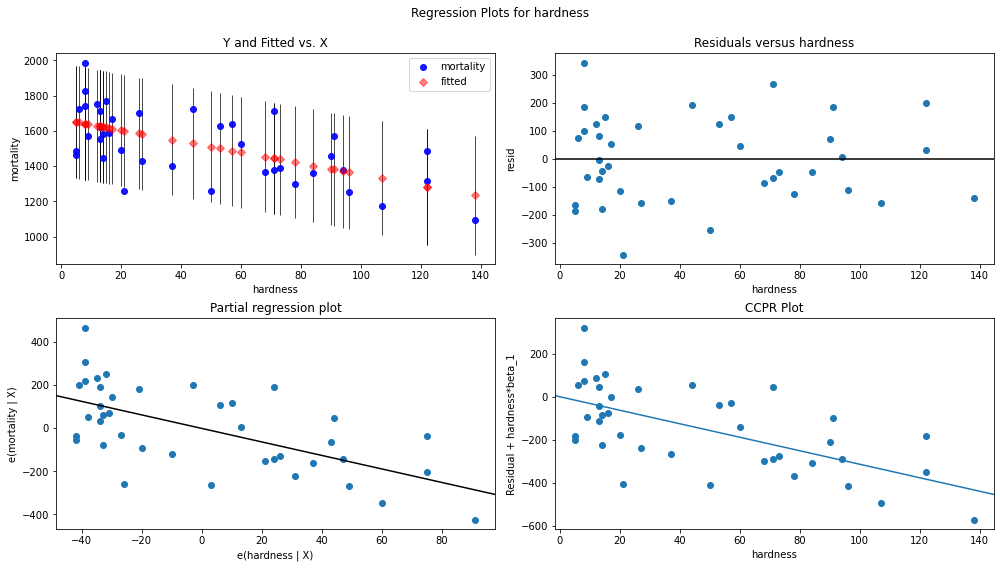

In [108]:
# modify figure size
fig = plt.figure(figsize=(14, 8))
# creating regression plots
fig = sm.graphics.plot_regress_exog(results,
                                    'hardness',
                                    fig=fig)

(array([1., 1., 7., 5., 7., 4., 7., 6., 1., 1.]),
 array([-341.52408074, -272.9009651 , -204.27784947, -135.65473383,
         -67.03161819,    1.59149745,   70.21461309,  138.83772873,
         207.46084437,  276.08396   ,  344.70707564]),
 <a list of 10 Patch objects>)

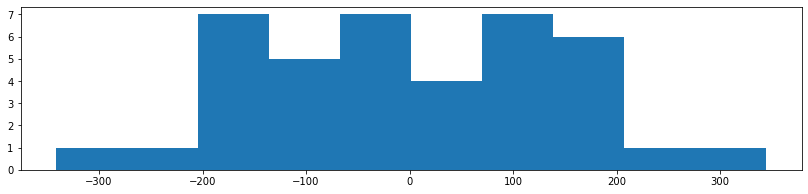

In [115]:
plt.hist(results.resid, bins=10)

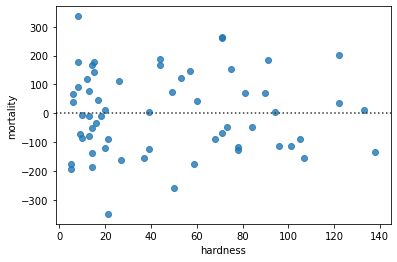

In [110]:
sns.residplot(x='hardness', y='mortality', data=df)

**Вывод:** На диаграмме рассеяния остатков наблюдется неравномерность в плотности отсчётов в области низких значений жёсткости.

In [ ]:
sns.distplot(results.resid)

**Вывод:** Гистограмма распределения остатков имеет очевидную ассиметрию в центральной части, что говорит о дефектах нормального распределения и следовательно о наличии нелинейных факторов не учтенных в регрессионной модели.

###### Задание 2.
Ответить на вопрос: сохраняется ли аналогичная зависимость для северных и южных городов по отдельности?

    Разделить данные на 2 группы
    Повторить аналогичные шаги из пункта 1 для каждой группы по отдельности


Выделим отдельные датафреймы для южных и северных городов

In [116]:
df.info()
df['location'].unique()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61 entries, 0 to 60
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   location   61 non-null     category
 1   town       61 non-null     category
 2   mortality  61 non-null     int64   
 3   hardness   61 non-null     int64   
dtypes: category(2), int64(2)
memory usage: 4.3 KB


[South, North]
Categories (2, object): [South, North]

In [117]:
df_south = df.loc[df['location'] == 'South'] 
df_south.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26 entries, 0 to 59
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   location   26 non-null     category
 1   town       26 non-null     category
 2   mortality  26 non-null     int64   
 3   hardness   26 non-null     int64   
dtypes: category(2), int64(2)
memory usage: 3.7 KB


In [118]:
df_north = df.loc[df['location'] == 'North'] 
df_north.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35 entries, 1 to 60
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   location   35 non-null     category
 1   town       35 non-null     category
 2   mortality  35 non-null     int64   
 3   hardness   35 non-null     int64   
dtypes: category(2), int64(2)
memory usage: 4.0 KB


**Основная статистика по южным городам**

In [119]:
df_south.describe()

,mortality,hardness
count,26.000000,26.000000
mean,1376.807692,69.769231
std,140.269175,40.360682
min,1096.000000,5.000000
25%,1259.250000,40.250000
50%,1364.000000,75.500000
75%,1485.750000,99.750000
max,1627.000000,138.000000


**Основная статистика по северным городам**

In [120]:
df_north.describe()

,mortality,hardness
count,35.000000,35.000000
mean,1633.600000,30.400000
std,136.936911,26.134494
min,1378.000000,6.000000
25%,1557.500000,12.500000
50%,1637.000000,17.000000
75%,1718.000000,44.000000
max,1987.000000,94.000000


###### Бокс-плоты для данных жёсткости воды и смертности



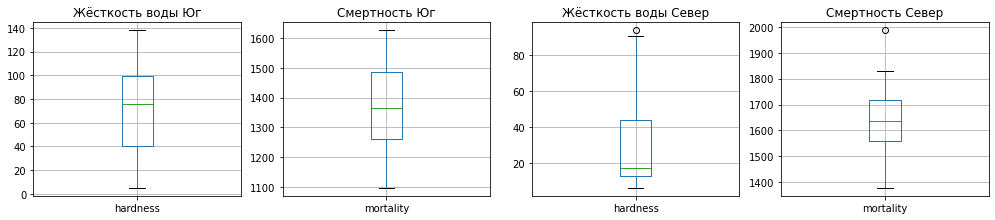

In [121]:
fig,axes = plt.subplots(nrows=1, ncols=4)
fig.tight_layout() # отодвинуть графики
#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 14,3


df_south['hardness'].plot(ax=axes[0], kind='box',
                   title='Жёсткость воды Юг', grid=True)
df_south['mortality'].plot(ax=axes[1], kind='box',
                   title='Смертность Юг', grid=True)
df_north['hardness'].plot(ax=axes[2], kind='box',
                   title='Жёсткость воды Север', grid=True)
df_north['mortality'].plot(ax=axes[3], kind='box',
                   title='Смертность Север', grid=True)

Типичной точкой отсечения, которую следует учитывать при удалении наблюдения, является значение DFFITS, равное 2-кратному sqrt (k / n), где k - количество переменных, а n - размер выборки. 

In [122]:
import math

k = 2
n = 35
DFFITS = 2* math.sqrt(k / n)
DFFITS

0.47809144373375745

In [112]:
# Оценить расстояние Кука:

from statsmodels.formula.api import ols

m = ols('PRICE ~ RM',bos).fit()
infl = m.get_influence()
sm_fr = infl.summary_frame()

NameError: name 'bos' is not defined

In [ ]:
Расчёт выброса для северных городов

In [123]:
# Расчёт выбросов  по «внутренним границам»:
q1 = df_north['hardness'].quantile(0.25)
q3 = df_north['hardness'].quantile(0.75)
iqr = q3 - q1
lower_bound_int = q1 - (1.5 * iqr) 
upper_bound_int = q3 + (1.5 * iqr)
print ('Значение выбросов столбца "hardness" по "внутренним границам" (1,5 межквартильного размаха):')
display(df_north[~df_north['hardness'].between(lower_bound_int, upper_bound_int, inclusive=True)])

# Расчёт выбросов для столбца mortality по «внутренним границам»:
q1 = df_north['mortality'].quantile(0.25)
q3 = df_north['mortality'].quantile(0.75)
iqr = q3 - q1
lower_bound_int = q1 - (1.5 * iqr) 
upper_bound_int = q3 + (1.5 * iqr)
print ('Значение выбросов столбца "mortality" по "внутренним границам" (1,5 межквартильного размаха):')
df_north[~df_north['mortality'].between(lower_bound_int, upper_bound_int, inclusive=True)]

Значение выбросов столбца "hardness" по "внутренним границам" (1,5 межквартильного размаха):


,location,town,mortality,hardness
21,North,Grimsby,1379,94


Значение выбросов столбца "mortality" по "внутренним границам" (1,5 межквартильного размаха):


,location,town,mortality,hardness
45,North,Salford,1987,8


**Вывод:** Имеются выбросы в столбцах данных mortality и hardness.

**a. Построить точечный график**

#### Диаграмма рассеяния

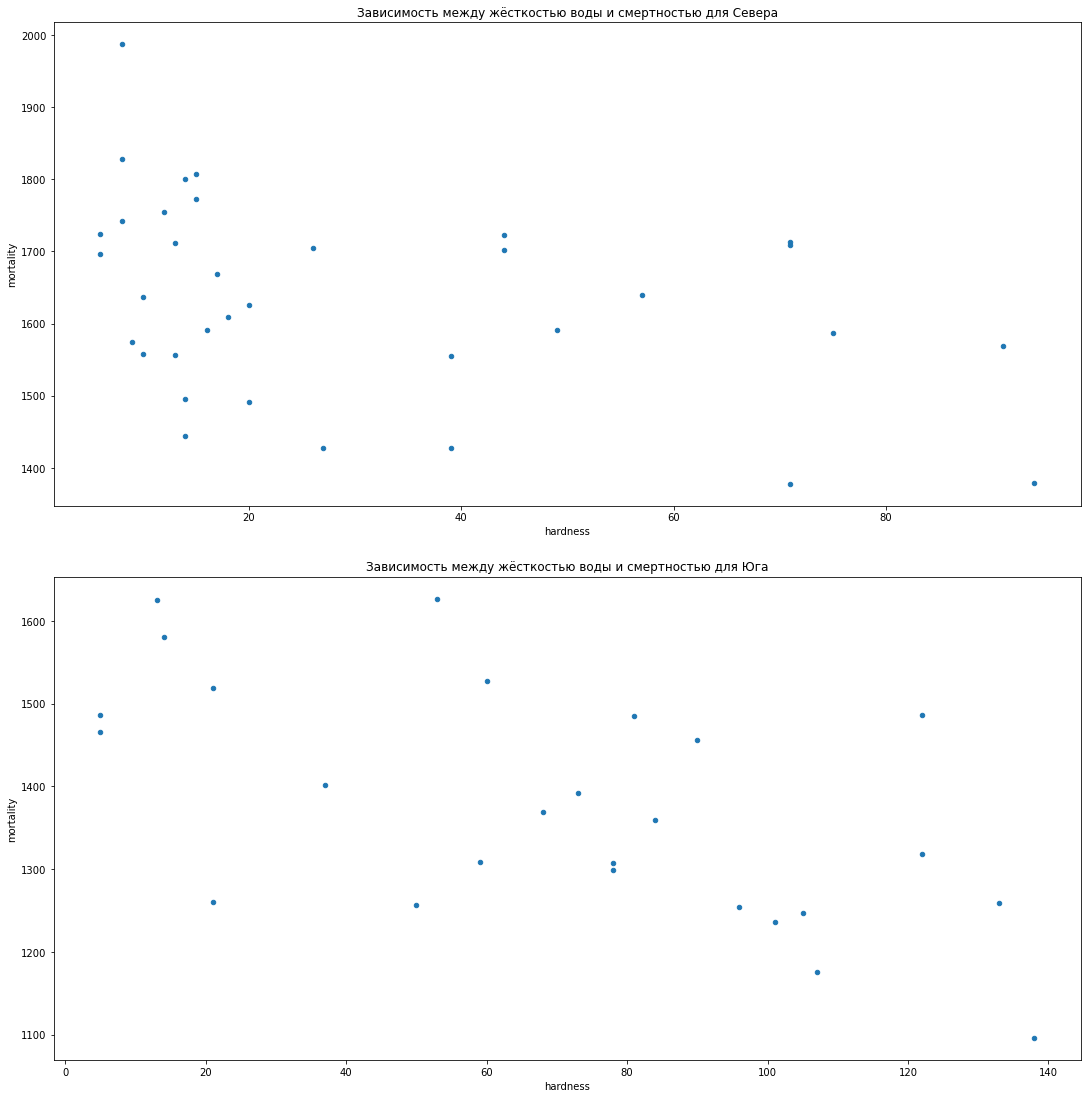

In [128]:
# посмотрим графически на взаимосвязь между жёсткостью воды и смертностью для Севера и Юга
fig,axes = plt.subplots(nrows=2, ncols=1)
fig.tight_layout(h_pad=5) # отодвинуть графики
rcParams['figure.figsize'] = 10,15


#plt.subplots_adjust(wspace=2)
 

df_north.plot(kind='scatter', ax=axes[0], x='hardness', 
        y='mortality', 
        title='Зависимость между жёсткостью воды и смертностью для Севера')
df_south.plot(kind='scatter', ax=axes[1],
        x='hardness', 
        y='mortality', 
        title='Зависимость между жёсткостью воды и смертностью для Юга')
        

**Вывод:** Визуально наблюдается обратная корреляция как для Юга, так и для Севера.

**b. Рассчитать коэффициенты корреляции Пирсона и Спирмена**

In [129]:
# считаем коэф. корреляции Пирсона и Спирмана для Севера:
display(df_north[['hardness',  'mortality']].corr())
# считаем коэф. корреляции Спирмана
df_north[['hardness',  'mortality']].corr(method='spearman')

,hardness,mortality
hardness,1.000000,-0.368598
mortality,-0.368598,1.000000


,hardness,mortality
hardness,1.000000,-0.404208
mortality,-0.404208,1.000000


**Вывод:** По сравнению с общей выборкой коэффициенты корреляции для выборки Севера снизились, связи между параметрами стали слабыми.

In [130]:
# считаем коэф. корреляции Пирсона и Спирмана для Севера:
display(df_south[['hardness',  'mortality']].corr())
# считаем коэф. корреляции Спирмана
df_south[['hardness',  'mortality']].corr(method='spearman')

,hardness,mortality
hardness,1.000000,-0.602153
mortality,-0.602153,1.000000


,hardness,mortality
hardness,1.000000,-0.595723
mortality,-0.595723,1.000000


**Вывод:** По сравнению с общей выборкой для выборки Юга  коэффициенты корреляции незначительно снизились, связи между параметрами на грани между сильными и слабыми.

**c. Построить модель линейной регрессии**

**Моделирование для региона Север:**

Создаем массивы:
**X** - по умолчанию многомерный массив (вектор) исходных параметров для прогноза, в нашем случае только 1 параметр -  *hardness*.
**y** - выходной прогнозный параметр -  *mortality* смертность.

In [131]:
X_north = df_north[['hardness']]
y_north = df_north['mortality']

Выполним разбиение с паметром - train_size=0.67 - **67%** для обучения модели, **33%** - для тестирования) 

In [132]:
X_train_north, X_test_north, y_train_north, y_test_north = train_test_split(
    
    
    X_north, y_north, train_size=0.67, random_state=42)
print (f'Всего строк в датасете для Севера: {len(df_north)}')
print(f"Количество строк в y_train - выборка для обучения: {len(y_train_north)}")
print(f"Количество строк в y_test -выборка дляя тестирования: {len(y_test_north)}")

Всего строк в датасете для Севера: 35
Количество строк в y_train - выборка для обучения: 23
Количество строк в y_test -выборка дляя тестирования: 12


In [ ]:
model_north = LinearRegression()
model_north.fit(X_train_north, y_train_north)  # метод обучается на данных и подбирает оптимальные коэффициенты

In [ ]:
sns.distplot(y_train_north)

Пробуем выполнить предсказание для известной части данных из X_test:

In [ ]:
y_pred_north = model.predict(X_test_north)
y_pred_north

**Сравним значения предсказанные моделью с реальными значениями:**

In [ ]:
i = 0
print('Для региона Север:')
for y_test_val in y_test_north:
    print(f'{i+1:2d}. Реальное значение смертности:{y_test_val} смоделированное значение смертности:{y_pred_north[i]:.0f}')
    i +=1

In [ ]:
print("Коэффициент модели для Севера: \n", model_north.coef_)
print('Поправка для Севера:', model_north.intercept_)

In [ ]:
print (f'Средняя смертность по всему датасету Севера:{df_north["mortality"].mean():.0f}')

**Вывод:** Поправка фактически равна среднему значению смертности, что уже без дальнейших вычислений говорит о неточности модели. 

In [ ]:
plt.title('Диаграмма рассеяния для Севера', fontsize=15)
plt.xlabel('Жёсткость воды', fontsize=12, color='black')
plt.ylabel('Смертность', fontsize=12, color='black')

plt.grid(True)
# Реальные данные
points1, = plt.plot(X_test_north, y_test_north, 'ro', color='green')
# Данные модели
points2, = plt.plot(X_test_north, y_pred_north,  color='red')

plt.legend((points1, points2), ['реальные данные', 'модель'])


**d. Рассчитать коэффициент детерминации**

In [ ]:
r2_model_north = model_north.score(X_test_north, y_test_north)
print(f'Коэффициент детерминации модели для Севера (метод score объекта LinearRegression):{r2_model_north:.2f}') 

In [ ]:
# https/www.geeksforgeeks.org/python-coefficient-of-determination-r2-score/

r2_north= r2_score(y_test_north,y_pred_north)
print(f'Коэффициент детерминации модели для Севера (расчёт функцией r2_score):{r2_north:.2f}')

**Вывод:** Модель по региону Север непригода для прогноза, что было ясно изначально ввиду низкого коэффициента корреляции.

**Моделирование для региона Юг:**

In [145]:
X_south = df_south[['hardness']]
y_south = df_south['mortality']

Выполним разбиение с паметром - train_size=0.67 - **67%** для обучения модели, **33%** - для тестирования) для датасета Юга:

In [146]:
X_train_south, X_test_south, y_train_south, y_test_south = train_test_split(X_south, y_south, 
                                                                            train_size=0.67, 
                                                                            random_state=42)
print (f'Всего строк в датасете для Юга: {len(df_south)}')
print(f"Количество строк в y_train - выборка для обучения: {len(y_train_south)}")
print(f"Количество строк в y_test -выборка дляя тестирования: {len(y_test_south)}")

Всего строк в датасете для Юга: 26
Количество строк в y_train - выборка для обучения: 17
Количество строк в y_test -выборка дляя тестирования: 9


In [147]:
model_south = LinearRegression()
model_south.fit(X_train_south, y_train_south)  # метод обучается на данных и подбирает оптимальные коэффициенты

LinearRegression()

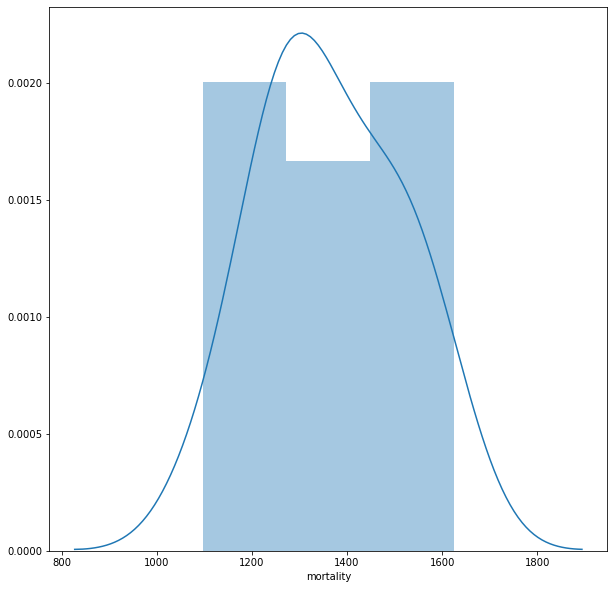

In [155]:
rcParams['figure.figsize'] = 10,10
sns.distplot(y_train_south)

Пробуем выполнить предсказание для известной части данных из X_test:

In [149]:
y_pred_south = model_south.predict(X_test_south)
y_pred_south

array([1209.95583268, 1599.47401874, 1266.55249219, 1209.95583268,
       1492.93913024, 1546.20657449, 1419.6963944 , 1599.47401874,
       1439.671686  ])

**Сравним значения предсказанные моделью с реальными значениями:**

In [150]:
i = 0
print('Для региона Юг:')
for y_test_val in y_test_south:
    print(f'{i+1:2d}. Реальное значение смертности:{y_test_val} смоделированное значение смертности:{y_pred_south[i]:.0f}')
    i +=1

Для региона Юг:
 1. Реальное значение смертности:1318 смоделированное значение смертности:1210
 2. Реальное значение смертности:1486 смоделированное значение смертности:1599
 3. Реальное значение смертности:1247 смоделированное значение смертности:1267
 4. Реальное значение смертности:1486 смоделированное значение смертности:1210
 5. Реальное значение смертности:1402 смоделированное значение смертности:1493
 6. Реальное значение смертности:1260 смоделированное значение смертности:1546
 7. Реальное значение смертности:1309 смоделированное значение смертности:1420
 8. Реальное значение смертности:1466 смоделированное значение смертности:1599
 9. Реальное значение смертности:1627 смоделированное значение смертности:1440


In [151]:
print("Коэффициент модели для Юга: \n", model_south.coef_)
print('Поправка для Юга:', model_south.intercept_)

Коэффициент модели для Юга: 
 [-3.32921527]
Поправка для Юга: 1616.1200950622008


In [152]:
print (f'Средняя смертность по всему датасету Юг:{df_south["mortality"].mean():.0f}')

Средняя смертность по всему датасету Юг:1377


**Вывод:** Поправка фактически больше среднего значения смертности, что уже без дальнейших вычислений говорит о неточности модели. 

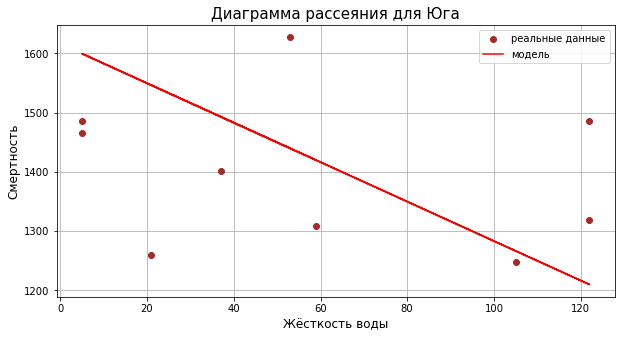

In [159]:
rcParams['figure.figsize'] = 10,5
plt.title('Диаграмма рассеяния для Юга', fontsize=15)
plt.xlabel('Жёсткость воды', fontsize=12, color='black')
plt.ylabel('Смертность', fontsize=12, color='black')
plt.grid(True)
# Реальные данные
points1, = plt.plot(X_test_south, y_test_south, 'ro', color='brown')
# Данные модели
points2, = plt.plot(X_test_south, y_pred_south,  color='red')

plt.legend((points1, points2), ['реальные данные', 'модель'])


**d. Рассчитать коэффициент детерминации**

In [160]:
r2_model_south = model_south.score(X_test_south, y_test_south)
print(f'Коэффициент детерминации модели для Юга (метод score объекта LinearRegression):{r2_model_south:.2f}') 

Коэффициент детерминации модели для Юга (метод score объекта LinearRegression):-0.99


In [161]:
# https/www.geeksforgeeks.org/python-coefficient-of-determination-r2-score/

r2_south= r2_score(y_test_south,y_pred_south)
print(f'Коэффициент детерминации модели для Севера (расчёт функцией r2_score):{r2_south:.2f}')

Коэффициент детерминации модели для Севера (расчёт функцией r2_score):-0.99


**Вывод:** Модель по региону Юг полностью непригода для прогноза.

**e. Вывести график остатков**

Построение диаграмм остатков выполним на при помощи библиотеки **statsmodels**

https://www.geeksforgeeks.org/how-to-create-a-residual-plot-in-python/

**Построение графика остатков для датасета Севера:**

In [162]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

X_north = df_north[['hardness']]
y_north = df_north['mortality']

In [163]:
X_train_north, X_test_north, y_train_north, y_test_north = train_test_split(X_north, 
                                                                            y_north, 
                                                                            test_size=0.33, 
                                                                            random_state=42)

In [164]:
X_const_north = sm.add_constant(X_train_north) # техническая особенность библиотеки, надо руками добавить константу

In [171]:
stat_model_north = sm.OLS(y_train_north, X_const_north)
results_north = stat_model_north.fit()
print(results_north.summary())

                            OLS Regression Results                            
Dep. Variable:              mortality   R-squared:                       0.195
Model:                            OLS   Adj. R-squared:                  0.156
Method:                 Least Squares   F-statistic:                     5.080
Date:                Fri, 27 Jan 2023   Prob (F-statistic):             0.0350
Time:                        12:55:33   Log-Likelihood:                -141.53
No. Observations:                  23   AIC:                             287.1
Df Residuals:                      21   BIC:                             289.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1689.7785     38.807     43.543      0.0

In [172]:
print(f'Коэффициент детерминации R2: {results_north.rsquared:.2f}')

Коэффициент детерминации R2: 0.19


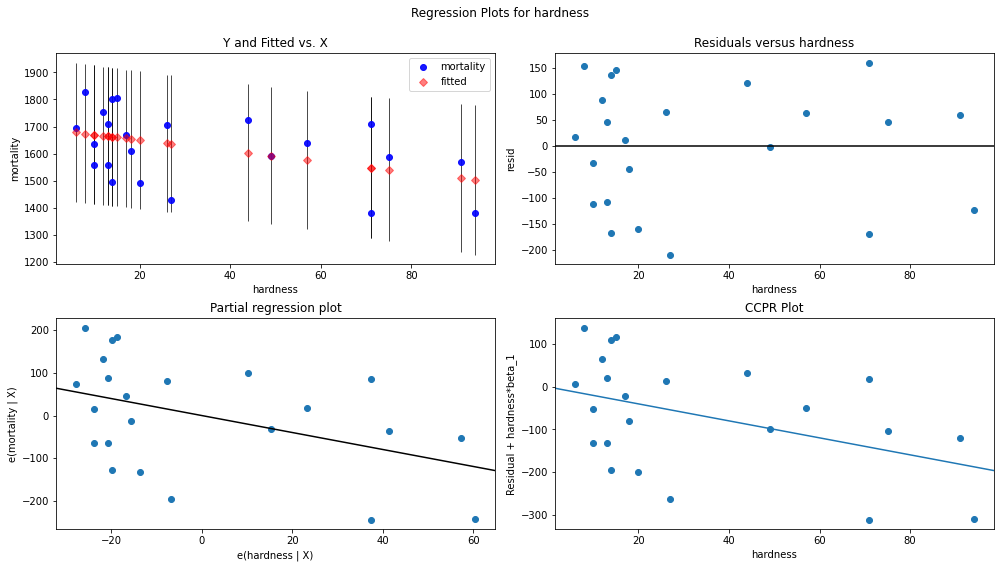

In [173]:
# modify figure size
fig = plt.figure(figsize=(14, 8))
# creating regression plots
fig = sm.graphics.plot_regress_exog(results_north,
                                    'hardness',
                                    fig=fig)

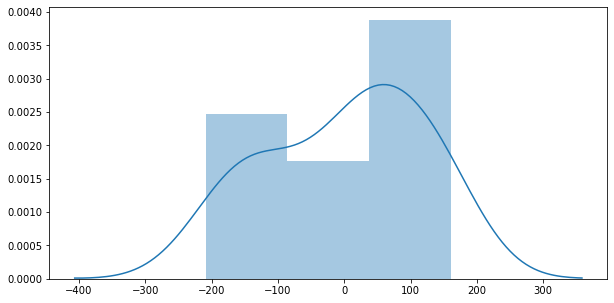

In [175]:
sns.distplot(results_north.resid)

**Вывод:** На графике распределения остатков наблюдается неравномерность.

**Построение графика остатков для датасета Юга:**

In [176]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

X_south = df_south[['hardness']]
y_south = df_south['mortality']

In [177]:
X_train_south, X_test_south, y_train_south, y_test_south = train_test_split(X_south, 
                                                                            y_south, 
                                                                            test_size=0.33, 
                                                                            random_state=42)

In [178]:
X_const_south = sm.add_constant(X_train_south) # техническая особенность библиотеки, надо руками добавить константу

In [180]:
stat_model_south = sm.OLS(y_train_south, X_const_south)
results_south = stat_model_south.fit()
print(results_south.summary())

                            OLS Regression Results                            
Dep. Variable:              mortality   R-squared:                       0.661
Model:                            OLS   Adj. R-squared:                  0.638
Method:                 Least Squares   F-statistic:                     29.24
Date:                Fri, 27 Jan 2023   Prob (F-statistic):           7.27e-05
Time:                        13:07:52   Log-Likelihood:                -99.492
No. Observations:                  17   AIC:                             203.0
Df Residuals:                      15   BIC:                             204.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1616.1201     51.369     31.461      0.0

C:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=17
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


In [172]:
print(f'Коэффициент детерминации R2: {results_south.rsquared:.2f}')

Коэффициент детерминации R2: 0.19


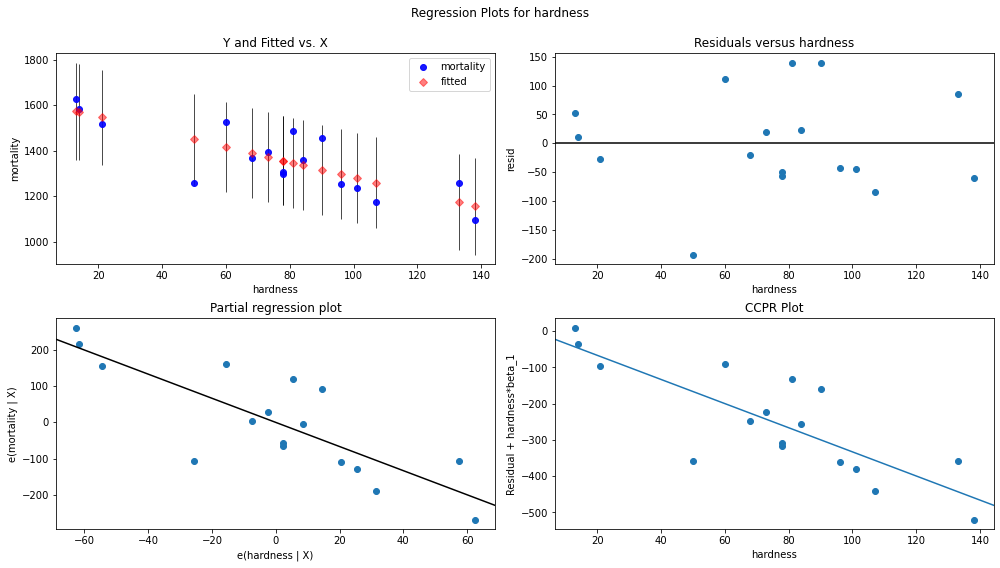

In [181]:
# modify figure size
fig = plt.figure(figsize=(14, 8))
# creating regression plots
fig = sm.graphics.plot_regress_exog(results_south,
                                    'hardness',
                                    fig=fig)

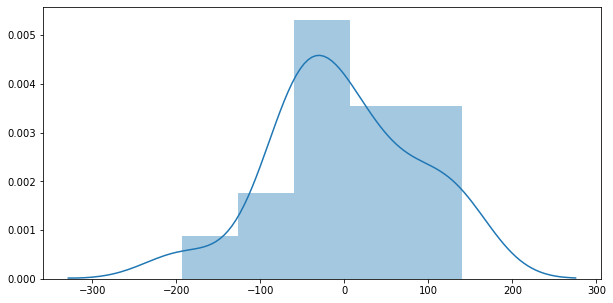

In [182]:
sns.distplot(results_south.resid)

**Вывод:** На графике распределения остатков наблюдается неравномерность.

In [ ]:
# Code source: Jaques Grobler
# License: BSD 3 clause

import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

# Load the diabetes dataset
diabetes_X, diabetes_y = datasets.load_diabetes(return_X_y=True)

# Use only one feature
diabetes_X = diabetes_X[:, np.newaxis, 2]

# Split the data into training/testing sets
diabetes_X_train = diabetes_X[:-20]
diabetes_X_test = diabetes_X[-20:]

# Split the targets into training/testing sets
diabetes_y_train = diabetes_y[:-20]
diabetes_y_test = diabetes_y[-20:]

# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(diabetes_X_train, diabetes_y_train)

# Make predictions using the testing set
diabetes_y_pred = regr.predict(diabetes_X_test)

# The coefficients
print("Coefficients: \n", regr.coef_)
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(diabetes_y_test, diabetes_y_pred))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(diabetes_y_test, diabetes_y_pred))

# Plot outputs
plt.scatter(diabetes_X_test, diabetes_y_test, color="black")
plt.plot(diabetes_X_test, diabetes_y_pred, color="blue", linewidth=3)

plt.xticks(())
plt.yticks(())

plt.show()

(array([1., 3., 3., 0., 2., 2., 3., 3., 2., 4.]),
 array([-208.92114663, -171.94439313, -134.96763963,  -97.99088613,
         -61.01413264,  -24.03737914,   12.93937436,   49.91612786,
          86.89288135,  123.86963485,  160.84638835]),
 <a list of 10 Patch objects>)

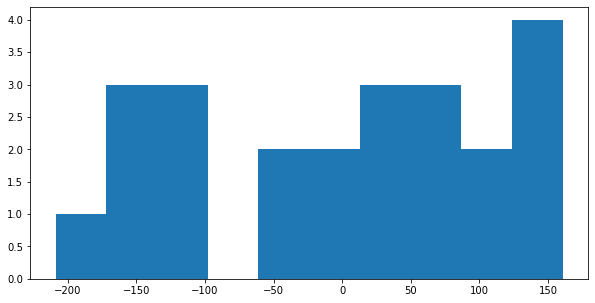

In [174]:
plt.hist(results_north.resid, bins=10)

In [ ]:
x = [1, 5, 10, 15, 20]
y = [1, 7, 3, 5, 11]
plt.plot(x, y, label='steel price')
plt.title('Chart price', fontsize=15)
plt.xlabel('Day', fontsize=12, color='blue')
plt.ylabel('Price', fontsize=12, color='blue')
plt.legend(['L1', 'L2'])
plt.grid(True)
plt.text(15, 4, 'grow up!')